# Global constants

In [1]:
# GRAIN_TYPE = 'Wheat'
# GRAIN_TYPE = 'Oats'
# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + 't2_kfold_dnn_separate.h5'

In [2]:
#Import libraries
import requests
import pydot
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt

#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold

print(tf.__version__)

2023-08-15 16:21:20.166156: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-15 16:21:20.617228: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-15 16:21:20.617627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-15 16:21:20.620692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 16:21:20.620763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2023-08-15 16:21:20.620773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-15 16:21:20.621518: I tensorflow/stream_executor/platform/d

# Helper Functions

In [4]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

def plot_loss_curve(history, output_name, epoch_size):
    loss_train = history.history[output_name + '_loss']
    loss_val = history.history['val_' + output_name + '_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss: ' + output_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(predictions, trueValues)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label='Ideal fit')
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

# 1. Load the Dataset
We are going to use one dataset from UCI Machine Learning Repository. You can download the Energy Efficient Dataset using the following link. You can use pandas to download and open the data set which is in excel format or load from your local machine.

In [5]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)

print("From USDA: ", URL)

df.head()

From USDA:  ../Datasets/processed/Corn.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary
0,0,HI BRED 31D58,6.0,3.3,26.23,0.5602,9.2688,142.982,-217.018,3.595,0.984
1,1,HI BRED 31D58,7.0,3.3,26.23,0.5602,11.9033,114.498,-245.502,3.476,1.067
2,2,HI BRED 31D58,8.0,3.3,26.23,0.5602,14.9916,85.785,-274.215,3.383,1.163
3,3,HI BRED 31D58,9.0,3.3,26.23,0.5602,17.7882,63.083,-296.917,3.252,1.205
4,4,HI BRED 31D58,10.0,3.3,26.23,0.5602,20.2646,38.844,-321.156,3.165,1.224


# 2. Overview of data


In [6]:
# Data summary
df.describe()

,Unnamed: 0,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary
count,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000
mean,667.980377,9.616604,5.283170,19.173464,0.732730,18.574415,7.843992,-462.193766,3.241382,0.900775
std,388.591085,3.036191,2.049772,7.206516,0.101502,6.337757,89.287814,190.960971,0.603906,0.508211
min,0.000000,5.000000,2.000000,8.060000,0.448800,8.002300,-179.974000,-1115.206000,2.405000,0.242000
25%,331.000000,7.000000,3.300000,13.910000,0.663100,13.112200,-54.978000,-573.131000,2.780000,0.477000
50%,662.000000,9.000000,4.400000,18.580000,0.748300,18.344300,11.128000,-402.701000,3.094000,0.821000
75%,1007.000000,12.000000,7.700000,25.430000,0.816100,24.152200,77.870000,-323.806000,3.526000,1.213000
max,1338.000000,18.000000,8.500000,34.400000,0.901700,29.897000,179.949000,-150.217000,5.979000,3.294000


In [7]:
# Dimension of the dataset
df.shape

(1325, 11)

In [8]:
# Check info about missing values in dataframe
df.isnull().sum()

Unnamed: 0                0
Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [9]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                    'Attn', 
                    'Phase', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary']]

# df_targets = df[['M%', 'Density']]
df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [10]:
# Perform train-test split on RAW DATA
X_trainVal, X_test, y_trainVal, y_test = train_test_split(dataset_x, dataset_y, 
                                                    test_size=0.2
                                                    ,random_state=42
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, 
                                                    test_size=0.15 #validation split
                                                    ,random_state=42
                                                    )

## Normalize datasets

In [11]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize Train set
X_train_norm = scaler_input.fit_transform(X_train)
y_train_norm = scaler_output.fit_transform(y_train)

# Normalize Validation set
X_val_norm = scaler_input.fit_transform(X_val)
y_val_norm = scaler_output.fit_transform(y_val)

# K-cross Validation
* Input features: 7
* Output targets: 2


## Defining the model

In [12]:
from keras import layers, Sequential, regularizers

# Define the model-building function
def my_model():
  
    
  inputLayer = Input(shape=(7,))

  denseLayer0 =Dense(128, activation='relu', name='l0')(inputLayer)
  # bn1 = BatchNormalization()(denseLayer1)

  denseLayer1 =Dense(64, activation='relu', name='l1')(denseLayer0)
  # bn1 = BatchNormalization()(denseLayer1)

  denseLayer2 =Dense(64, activation='relu', name='l2')(denseLayer1)
  # bn2 = BatchNormalization()(denseLayer2)

  y1_output = Dense(1, activation = 'linear', name='y1_output')(denseLayer2)
  # y1_output = Dense(1, activation = 'linear', name='y1_output')(denseLayer1)

  denseLayer3 =Dense(32, activation='relu', name='l3')(denseLayer2)
  # denseLayer3 =Dense(32, activation='relu', name='l3')(denseLayer1)
  # bn3 = BatchNormalization()(denseLayer3)

  y2_output = Dense(1, activation = 'linear', name='y2_output')(denseLayer3)
      
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

  my_model = Model(inputs = inputLayer,
                   outputs = [y1_output, y2_output])
  
  my_model.compile(
      optimizer = opt,
      loss = ['mse', 'mse'],
      metrics = {'y1_output':'accuracy', 'y2_output':'accuracy'},
  )

  return my_model

plot_model(my_model(), show_shapes=True, show_layer_names=True)
my_model().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
l0 (Dense)                      (None, 128)          1024        input_2[0][0]                    
__________________________________________________________________________________________________
l1 (Dense)                      (None, 64)           8256        l0[0][0]                         
__________________________________________________________________________________________________
l2 (Dense)                      (None, 64)           4160        l1[0][0]                         
____________________________________________________________________________________________

2023-08-15 16:21:21.483307: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 16:21:21.484618: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-15 16:21:21.484843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 16:21:21.484958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth

## Run KCV on model

In [13]:
from sklearn.model_selection import KFold
import numpy as np

NUM_EPOCHS = 100
BATCH_SIZE = 10
K_FOLD_SPLITS = 10


# Define the cross-validation process to be used inside cross_val_Score evaluation
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y1 = y_train_norm[:,0]
Y2 = y_train_norm[:,1]


X = X_train_norm

i = 0
arr_loss = list()
min_loss = 1000000
best_model = None
history = None
history_best_model = None

# Perform k-fold cross-validation
for train_indices, test_indices in cv.split(X_train):
  print('####################### Iteration  ', i, ' #######################')
  trainX, testX = np.array(X[train_indices]), np.array(X[test_indices])
  # trainY = np.vstack((Y1[train_indices], Y2[train_indices])).T
  # testY = np.vstack((Y1[test_indices], Y2[test_indices])).T
  trainY = (Y1[train_indices], Y2[train_indices])
  testY = (Y1[test_indices], Y2[test_indices])

  model = my_model()
  history = model.fit(trainX, trainY,
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data = (testX, testY)
  )


  #testing on validation set process
  loss, Y1_loss, Y1_acc, Y2_loss, Y2_acc = model.evaluate(x = testX, y = testY, verbose=1)
  print(f"Loss = {loss}, Y1_loss = {Y1_loss}, Y1_rmse = {Y1_acc}, \n Y2_loss = {Y2_loss}, Y2_rmse = {Y2_acc}")

  if loss < min_loss:
    best_model = model
    history_best_model = history
    min_loss = loss

  arr_loss.append(loss)
  print('Loss array: ', arr_loss)
  i+=1

# Saving the best model within the k folds
best_model.save(FILENAME_BEST_MODEL)

2023-08-15 16:21:22.253878: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-15 16:21:22.254118: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4491685000 Hz


####################### Iteration   0  #######################
Epoch 1/100


2023-08-15 16:21:22.430795: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


81/81 [==============================] - 1s 4ms/step - loss: 0.4920 - y1_output_loss: 0.1897 - y2_output_loss: 0.3022 - y1_output_accuracy: 0.0020 - y2_output_accuracy: 0.0260 - val_loss: 0.2389 - val_y1_output_loss: 0.0459 - val_y2_output_loss: 0.1930 - val_y1_output_accuracy: 0.0000e+00 - val_y2_output_accuracy: 0.0330
Epoch 2/100
81/81 [==============================] - 0s 946us/step - loss: 0.1871 - y1_output_loss: 0.0441 - y2_output_loss: 0.1430 - y1_output_accuracy: 0.0096 - y2_output_accuracy: 0.0280 - val_loss: 0.1109 - val_y1_output_loss: 0.0302 - val_y2_output_loss: 0.0807 - val_y1_output_accuracy: 0.0000e+00 - val_y2_output_accuracy: 0.0330
Epoch 3/100
81/81 [==============================] - 0s 964us/step - loss: 0.1067 - y1_output_loss: 0.0375 - y2_output_loss: 0.0692 - y1_output_accuracy: 0.0081 - y2_output_accuracy: 0.0193 - val_loss: 0.0647 - val_y1_output_loss: 0.0247 - val_y2_output_loss: 0.0399 - val_y1_output_accuracy: 0.0000e+00 - val_y2_output_accuracy: 0.0330
Epo

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

In [14]:
print(list(history_best_model.history.keys()))

['loss', 'y1_output_loss', 'y2_output_loss', 'y1_output_accuracy', 'y2_output_accuracy', 'val_loss', 'val_y1_output_loss', 'val_y2_output_loss', 'val_y1_output_accuracy', 'val_y2_output_accuracy']


No handles with labels found to put in legend.


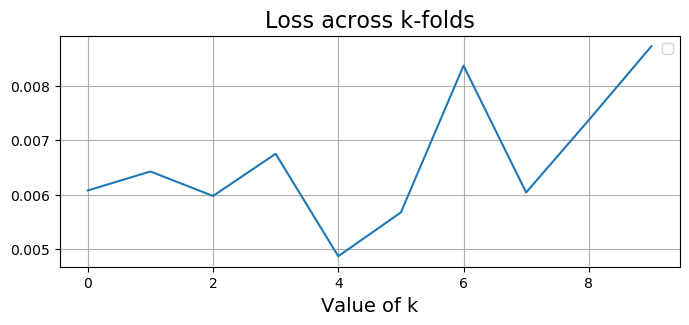

In [15]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

### Loss curves

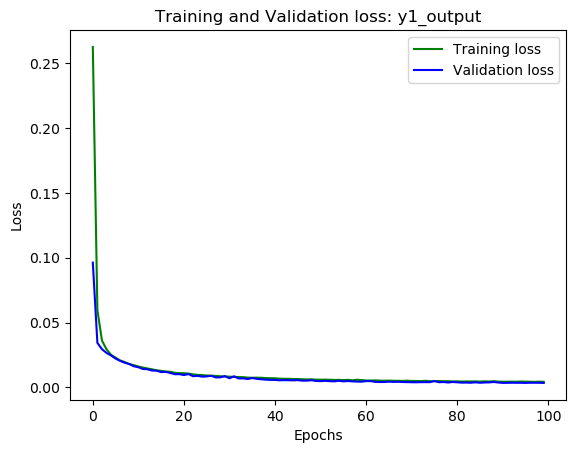

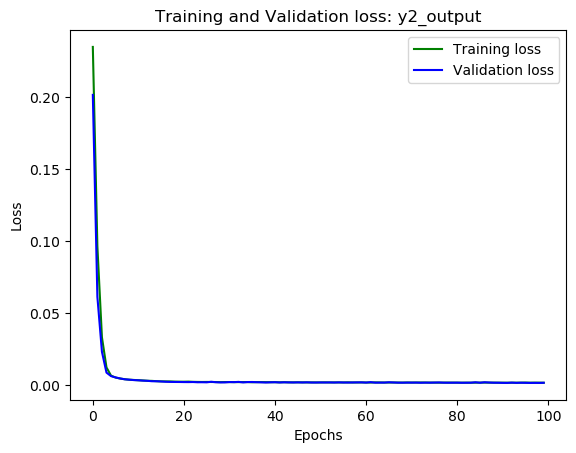

In [16]:
# Training and Validation Loss
plot_loss_curve(history_best_model, 
                output_name='y1_output',
                epoch_size=NUM_EPOCHS)

plot_loss_curve(history_best_model, 
                output_name='y2_output',
                epoch_size=NUM_EPOCHS)

## Prediction on Test Dataset

In [17]:
# Normalize the test dataset
X_test_norm = scaler_input.transform(X_test)
y_test_norm = scaler_output.transform(y_test)

In [18]:
import time

start_time = time.time()
(pred_bc, pred_mc) = best_model.predict(X_test_norm)
end_time = time.time()

# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")

test_results = np.vstack( (pred_bc.flatten(), pred_mc.flatten()) ).T
Y_pred = scaler_output.inverse_transform(test_results)
Y_actual = np.array(y_test)

Elapsed time: 0.04 seconds


## Plotting Real vs Predicted values

Maxval here is:  36.09418
Maxval here is:  0.9169517


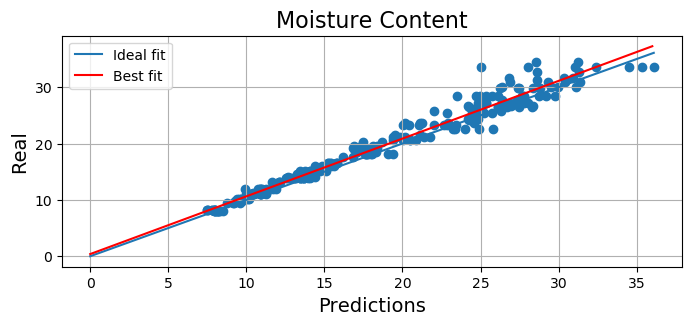

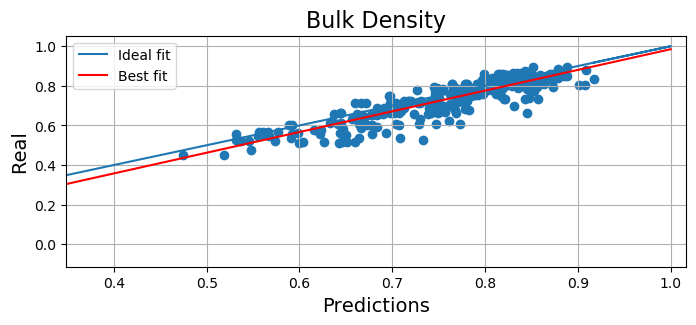

In [23]:
# MOISTURE CONTENT
scatter_plot(trueValues=Y_actual[:,1], 
             predictions=Y_pred[:,1], 
             title="Moisture Content")
a, b = np.polyfit(Y_pred[:, 1], Y_actual[:, 1], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,1]), max(Y_actual[:,1])), 1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
# plt.savefig('obj_2_MC.svg', dpi=300, transparent=True)
plt.savefig('../Poster/Results/obj_2_MC.svg', dpi=300, 
                        bbox_inches='tight',
                        transparent=True)

# BULK DENSITY
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Bulk Density")
plt.xlim([min(min(Y_pred[:,0]), min(Y_actual[:,0]))-0.1, max(max(Y_pred[:,0]), max(Y_actual[:,0]))+0.1])

a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0]))+0.1, 0.1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_2_BD.svg', 
                        dpi=300, 
                        bbox_inches='tight',
                        transparent=True)

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [20]:
from sklearn.metrics import r2_score

# MOISTURE CONTENT
#   - R-squared
mc_r2_score = calculate_r_squared(y_true=Y_actual[:, 1], y_pred=Y_pred[:, 1])
print('MC: ', mc_r2_score)

# BULK DENSITY
#   - R-squared
bd_r2_score = calculate_r_squared(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print('BD: ', bd_r2_score)

MC:  0.96921472362042
BD:  0.7895556011030692


### RMSE

In [21]:
from sklearn.metrics import mean_squared_error

#MC
rmse_mc = np.sqrt(mean_squared_error(Y_actual[:, 1], Y_pred[:, 1]))
print('RMSE_MC: ', rmse_mc)

#BD
rmse_bd = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
print('RMSE_BD: ', rmse_bd)

RMSE_MC:  1.5648639259935184
RMSE_BD:  0.05531198778021185
